<a href="https://colab.research.google.com/github/SiriuXProtocoL/Tensorflow_examples/blob/main/05_overfitting_underfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Overfitting?
1.   Get more training data.
2.   Reduce the capacity of the network.
3.   Add weight regularization.
4.   Add dropouts.

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.3.0


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 4.5MB/s 


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

###The Higgs Dataset
- It contains 11 000 000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
FEATURES = 28

2816409600/2816407858 [==============================] - 106s 0us/step


- The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [10]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

- That csv reader class returns a list of scalars for each record.
- The following function repacks that list of scalars into a (feature_vector, label) pair.

In [11]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

- TensorFlow is most efficient when operating on large batches of data.

- So instead of repacking each row individually make a new Dataset that takes batches of 10000-examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:

In [12]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

- Have a look at some of the records from this new packed_ds.

- The features are not perfectly normalized,

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


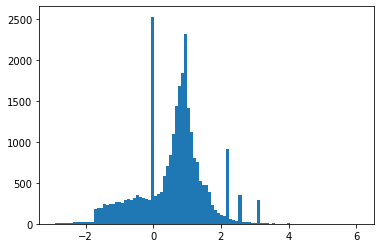

In [13]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

- To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training

In [14]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

- The Dataset.skip and Dataset.take methods make this easy
-  use the Dataset.cache method to ensure that the loader doesn't need to re-read the data from the file on each epoch

In [15]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [16]:
train_ds


<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

- These datasets return individual examples. 
- Use the .batch method to create batches of an appropriate size for training.
- Before batching also remember to .shuffle and .repeat the training set.

In [17]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

###Demonstrate overfitting
##Training Procedure
- Many models train better if you gradually reduce the learning rate during training. Use optimizers.schedules to reduce the learning rate over time
-  schedules.InverseTimeDecay hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on

In [18]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

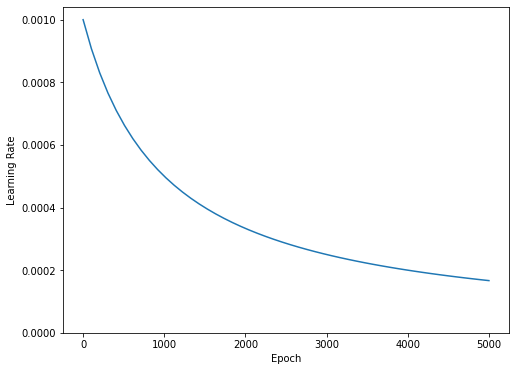

In [19]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

- The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply prints a . for each epoch, and a full set of metrics every 100 epochs.

- Next include callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.

- Use callbacks.TensorBoard to generate TensorBoard logs for the training

In [20]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

- Similarly each model will use the same Model.compile and Model.fit settings

In [21]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

###Tiny Model

- Start by training a model:

In [22]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [23]:
size_histories = {}

In [24]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch: 0, accuracy:0.4997,  binary_crossentropy:0.7643,  loss:0.7643,  val_accuracy:0.4810,  val_binary_crossentropy:0.7586,  val_loss:0.7586,  
....................................................................................................
Epoch: 100, accuracy:0.5981,  binary_crossentropy:0.6274,  loss:0.6274,  val_accuracy:0.5890,  val_binary_crossentropy:0.6285,  val_loss:0.6285,  
......................................................

- Now check how the model did:

(0.5, 0.7)

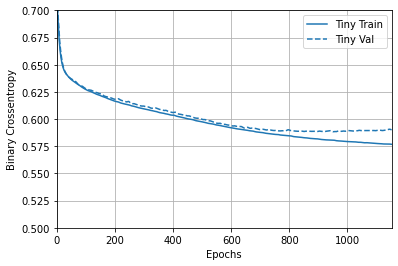

In [25]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

###Small model
- To see if you can beat the performance of the small model, progressively train some larger models.

- Try two hidden layers with 16 units each

In [26]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [27]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4801,  binary_crossentropy:0.7821,  loss:0.7821,  val_accuracy:0.4880,  val_binary_crossentropy:0.7327,  val_loss:0.7327,  
....................................................................................................
Epoch: 100, accuracy:0.6239,  binary_crossentropy:0.6099,  loss:0.6099,  val_accuracy:0.5800,  val_binary_crossentropy:0.6267,  val_loss:0.

###Medium model

- Now try 3 hidden layers with 64 units each:

In [28]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

- And train the model using the same data:

In [29]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4910,  binary_crossentropy:0.6935,  loss:0.6935,  val_accuracy:0.5050,  val_binary_crossentropy:0.6806,  val_loss:0.6806,  
....................................................................................................
E

###Large model

- see how quickly it begins overfitting.

In [30]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

- And, again, train the model using the same data:

In [31]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5073,  binary_crossentropy:0.8477,  loss:0.8477,  val_accuracy:0.4700,  val_binary_crossentr

###Plot the training and validation losses
- The solid lines show the training loss
- The dashed lines show the validation loss (remember: a lower validation loss indicates a better model)

Text(0.5, 0, 'Epochs [Log Scale]')

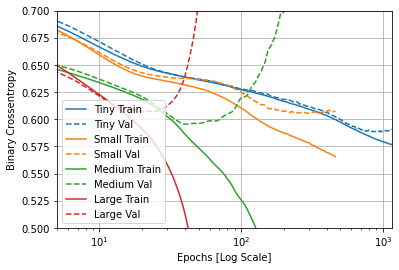

In [32]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

- This is apparent if you plot and compare the validation metrics to the training metrics.

    - It's normal for there to be a small difference.
    - If both metrics are moving in the same direction, everything is fine.
    - If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
    - If the validation metric is going in the wrong direction, the model is clearly overfitting.


**here the tiny model performed well**
- All the above training runs used the callbacks.EarlyStopping to end the training once it was clear the model was not making progress

###View in TensorBoard
- Open an embedded TensorBoard viewer inside a notebook
- TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

- It's also included in an iframe for convenience

In [34]:

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2359), started 0:00:44 ago. (Use '!kill 2359' to kill it.)

<IPython.core.display.Javascript object>

In [36]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [ ]:
#tensorboard dev upload --logdir  {logdir}/sizes
#to continuously upload the logs

###Strategies to prevent overfitting
- We will be uising the tiny model for the base level comparisions

In [37]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpl1euzt_p/tensorboard_logs/regularizers/Tiny')

In [38]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

###Add weight regularization
- there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.
-  a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". 
- This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

    - L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

    - L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

- L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

- In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [39]:
#training the large model with l2 regularization
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5191,  binary_crossentropy:0.8159,  loss:2.3426,  val_accuracy:0.5650,  val_binary_crossentr

- l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2 to the total loss of the network.

- That is why we're monitoring the binary_crossentropy directly. Because it doesn't have this regularization component mixed in.

- So, that same "Large" model with an L2 regularization penalty performs much better:

(0.5, 0.7)

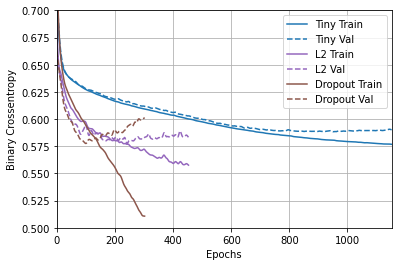

In [42]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

- As you can see, the "L2" regularized model is now much more competitive with the the "Tiny" model. This "L2" model is also much more resistant to overfitting than the "Large" model it was based on despite having the same number of parameters.
More info

- There are two important things to note about this sort of regularization.

- First: if you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

*result = l2_model(features)*
*regularization_loss=tf.add_n(l2_model.losses)*

- Second: This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

- There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like optimizers.FTRL and optimizers.AdamW

###Add dropout
- Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

- The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

- Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

- The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

- In tf.keras you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

- Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [40]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

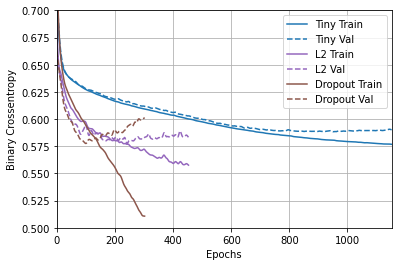

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

- It's clear from this plot that both of these regularization approaches improve the behavior of the "Large" model. But this still doesn't beat even the "Tiny" baseline.

###Combined L2 + dropout

In [43]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

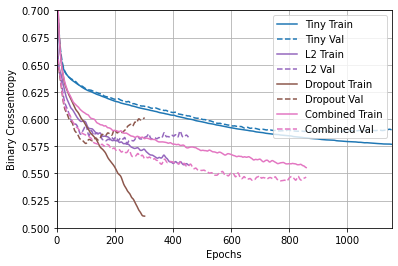

In [44]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

- This model with the "Combined" regularization is obviously the best one so far

In [45]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")